_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: *Jannis Ahlert, Julius Grote , Hun Seok Choi*

LLM Disclaimer: *Github Copilot and Chat GPT, used for autompletion and debugging.*

# Coding Lab 5

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
import scipy.io as io

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

%matplotlib inline
plt.style.use("../matplotlib_style.txt")

Last updated: 2025-05-22 16:10:07CEST

Python implementation: CPython
Python version       : 3.10.0
IPython version      : 8.35.0

sklearn: 1.6.1

numpy     : 2.2.5
scipy     : 1.15.2
matplotlib: 3.10.1

Watermark: 2.5.0



# Task 1: Fit RF on simulated data

We will start  with toy data generated from an LNP model neuron to make sure everything works right. The model LNP neuron consists of one Gaussian linear filter, an exponential nonlinearity and a Poisson spike count generator. We look at it in discrete time with time bins of width $\delta t$. The model is:

$$
c_t \sim Poisson(r_t)\\
r_t = \exp(w^T s_t) \cdot \Delta t \cdot R
$$

Here, $c_t$ is the spike count in time window $t$ of length $\Delta t$, $s_t$ is the stimulus and $w$ is the receptive field of the neuron. The receptive field variable `w` is 15 × 15 pixels and normalized to $||w||=1$. A stimulus frame is a 15 × 15 pixel image, for which we use uncorrelated checkerboard noise (binary) with a stimulus intesity of 5 (peak to peak). R can be used to bring the firing rate into the right regime (e.g. by setting $R=50$).      

For computational ease, we reformat the stimulus and the receptive field in a 225 by 1 array. The function ```sample_lnp``` can be used to generate data from this model. It returns a spike count vector `c` with samples from the model (dimensions: 1 by nT = $T/\Delta t$), a stimulus matrix `s` (dimensions: 225 × nT) and the mean firing rate `r` (dimensions: nT × 1). 

Here we assume that the receptive field influences the spike count instantaneously just as in the above equations. Implement a Maximum Likelihood approach to fit the receptive field. 

To this end derive mathematically and implement the log-likelihood function $L(w)$ and its gradient $\frac{L(w)}{dw}$ with respect to $w$ (`negloglike_lnp`). The log-likelihood of the model is
$$L(w) = \log \prod_t \frac{r_t^{c_t}}{c_t!}\exp(-r_t).$$

Make sure you include intermediate steps of the mathematical derivation in your answer, and you give as final form the maximally simplified expression, substituting the corresponding variables.

Plot the stimulus for one frame, the cell's response over time and the spike count vs firing rate. Plot the true and the estimated receptive field. 

*Grading: 2 pts (calculations) + 4 pts (generation) + 4 pts (implementation)*


### Calculations (2 pts)
_You can add your calculations in_ $\LaTeX$ _here_. 

$L(\omega) = \ldots$

$\frac{dL(\omega)}{d\omega} = \ldots$

$$
L(w)
= \log \prod_{t=1}^{n_T} \frac{r_t^{\,c_t}}{c_t!} e^{-r_t}
= \sum_{t=1}^{n_T} \bigl[c_t \log r_t - r_t - \log(c_t!)\bigr].
$$

$$
\text{where}\quad
r_t = \exp\bigl(w^\top s_t\bigr)\,\Delta t\,R.
$$

Thus
$$
\begin{aligned}
L(w)
&= \sum_{t=1}^{n_T} \Bigl[\,c_t\bigl(w^\top s_t + \log(\Delta t\,R)\bigr)
- \exp(w^\top s_t)\,\Delta t\,R
- \log(c_t!)\Bigr],\\
-\,L(w)
&= \sum_{t=1}^{n_T} \Bigl[\exp(w^\top s_t)\,\Delta t\,R
- c_t\,(w^\top s_t)\Bigr]
+ \underbrace{\sum_{t=1}^{n_T}\bigl[-\,c_t\log(\Delta t\,R) + \log(c_t!)\bigr]}_{\text{constant in }w}.
\end{aligned}
$$

Discarding the constant term, our objective is
$$
\mathcal{J}(w)
= \sum_{t=1}^{n_T} \Bigl[\exp(w^\top s_t)\,\Delta t\,R \;-\; c_t\,(w^\top s_t)\Bigr].
$$

Its gradient is
$$
\nabla_w \mathcal{J}(w)
= \sum_{t=1}^{n_T} \Bigl[\exp(w^\top s_t)\,\Delta t\,R - c_t\Bigr]\,s_t
= \sum_{t=1}^{n_T} (r_t - c_t)\,s_t.
$$

### Generate data (2 pts)

Text(0.5, 1.0, 'Gaussian RF')

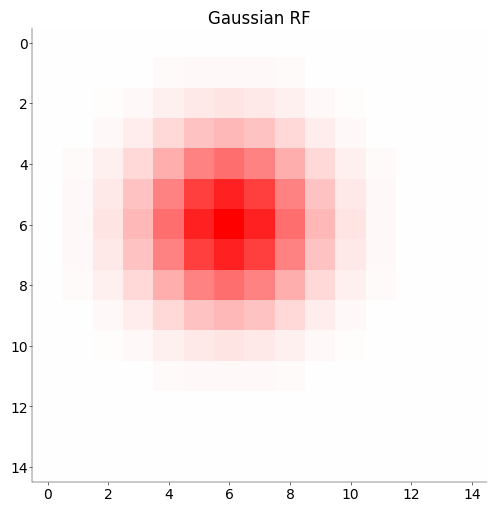

In [2]:
def gen_gauss_rf(D: int, width: float, center: tuple = (0, 0)) -> np.ndarray:
    """
    Generate a Gaussian receptive field.

    Args:
        D (int): Size of the receptive field (DxD).
        width (float): Width parameter of the Gaussian.
        center (tuple, optional): Center coordinates of the receptive field. Defaults to (0, 0).

    Returns:
        np.ndarray: Gaussian receptive field.
    """

    sz = (D - 1) / 2
    x, y = np.meshgrid(np.arange(-sz, sz + 1), np.arange(-sz, sz + 1))
    x = x + center[0]
    y = y + center[1]
    w = np.exp(-(x**2 / width + y**2 / width))
    w = w / np.sum(w.flatten())

    return w


w = gen_gauss_rf(15, 7, (1, 1))

vlim = np.max(np.abs(w))
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(w, cmap="bwr", vmin=-vlim, vmax=vlim)
ax.set_title("Gaussian RF")

In [3]:
def sample_lnp(
    w: np.array, nT: int, dt: float, R: float, s_i: float, random_seed: int = 10
):
    """Generate samples from an instantaneous LNP model neuron with
    receptive field kernel w.

    Parameters
    ----------

    w: np.array, (Dx * Dy, )
        (flattened) receptive field kernel.

    nT: int
        number of time steps

    dt: float
        duration of a frame in s

    R: float
        rate parameter

    s_i: float
        stimulus intensity peak to peak

    random_seed: int
        seed for random number generator

    Returns
    -------

    c: np.array, (nT, )
        sampled spike counts in time bins

    r: np.array, (nT, )
        mean rate in time bins

    s: np.array, (Dx * Dy, nT)
        stimulus frames used

    Note
    ----

    See equations in task description above for a precise definition
    of the individual parameters.

    """

    rng = np.random.default_rng(random_seed)

    # ------------------------------------------------
    # Generate samples from an instantaneous LNP model
    # neuron with receptive field kernel w. (1 pt)
    # ------------------------------------------------
    D = w.shape[0]
    # Stimulus: Gaussian IID
    s = rng.normal(loc=0.0, scale=s_i, size=(D, nT))
    # Linear filter output
    lin = w @ s  # shape (nT,)
    r = np.exp(lin) * dt * R  # shape (nT,)
    # Generate Poisson spikes
    c = rng.poisson(lam=r)
    return c, r, s

In [4]:
D = 15  # number of pixels
nT = 1000  # number of time bins
dt = 0.1  # bins of 100 ms
R = 50  # firing rate in Hz
s_i = 5  # stimulus intensity

w = gen_gauss_rf(D, 7, (1, 1))
w = w.flatten()

c, r, s = sample_lnp(w, nT, dt, R, s_i)

Plot the stimulus for one frame, the cell's response over time and the spike count vs firing rate.

/var/folders/yj/hdkffs_95ls2_lm_zcg93cwh0000gn/T/ipykernel_69809/851930843.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


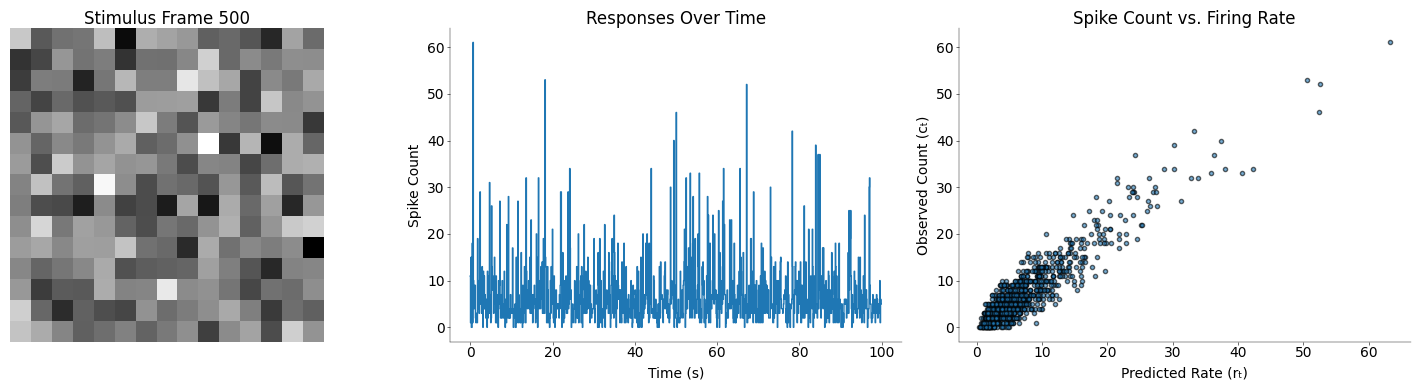

In [5]:
mosaic = mosaic = [["stim", "responses", "count/rate"]]

fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(15, 4))
# -----------------------------------------------------------------------------------------------------------
# Plot the stimulus for one frame, the cell's responses over time and spike count vs firing rate (1 pt)
# -----------------------------------------------------------------------------------------------------------

# Plot the stimulus for one frame
t0 = nT // 2
D = s.shape[0]
side = int(np.sqrt(D))
stim_frame = s[:, t0].reshape(side, side)

ax["stim"].imshow(stim_frame, cmap="gray", aspect="equal")
ax["stim"].set_title(f"Stimulus Frame {t0}")
ax["stim"].axis("off")

# Plot the cell's responses (spike counts) over time
time = np.arange(nT) * dt
ax["responses"].plot(time, c, drawstyle="steps-mid")
ax["responses"].set_xlabel("Time (s)")
ax["responses"].set_ylabel("Spike Count")
ax["responses"].set_title("Responses Over Time")

# Plot spike count vs. predicted firing rate
ax["count/rate"].scatter(r, c, alpha=0.6, edgecolor="k")
ax["count/rate"].set_xlabel("Predicted Rate (rₜ)")
ax["count/rate"].set_ylabel("Observed Count (cₜ)")
ax["count/rate"].set_title("Spike Count vs. Firing Rate")

plt.tight_layout()
plt.show()

### Implementation (3 pts)

Implement the negative log-likelihood of the LNP and its gradient with respect to the receptive field using the simplified equations you calculated earlier _(1 pt)_

In [6]:
def negloglike_lnp(
    w: np.array, c: np.array, s: np.array, dt: float = 0.1, R: float = 50
) -> float:
    """Implements the negative (!) log-likelihood of the LNP model

    Parameters
    ----------

    w: np.array, (Dx * Dy, )
      current receptive field

    c: np.array, (nT, )
      spike counts

    s: np.array, (Dx * Dy, nT)
      stimulus matrix


    Returns
    -------

    f: float
      function value of the negative log likelihood at w

    """

    # ------------------------------------------------
    # Implement the negative log-likelihood of the LNP
    # ------------------------------------------------

    lin = w @ s
    r = np.exp(lin) * dt * R
    # Negative log-likelihood (omit constant terms)
    return np.sum(r) - c.dot(lin)


def deriv_negloglike_lnp(
    w: np.array, c: np.array, s: np.array, dt: float = 0.1, R: float = 50
) -> np.array:
    """Implements the gradient of the negative log-likelihood of the LNP model

    Parameters
    ----------

    see negloglike_lnp

    Returns
    -------

    df: np.array, (Dx * Dy, )
      gradient of the negative log likelihood with respect to w

    """

    # --------------------------------------------------------------
    # Implement the gradient with respect to the receptive field `w`
    # --------------------------------------------------------------
    lin = w @ s
    r = np.exp(lin) * dt * R

    return s @ (r - c)

The helper function `check_grad` in `scipy.optimize` can help you to make sure your equations and implementations are correct. It might be helpful to validate the gradient before you run your optimizer.

In [14]:
# Check gradient
from scipy.optimize import minimize
from scipy.optimize import check_grad

# Initial guess
w0 = np.zeros_like(w)

# Perform the gradient check
error = check_grad(negloglike_lnp, deriv_negloglike_lnp, w0, c, s, dt, R)
print(f"Gradient check error: {error:.2e}")

Gradient check error: 1.43e-02


Fit receptive field maximizing the log likelihood.

The scipy.optimize package also has suitable functions for optimization. If you generate a large number of samples, the fitted receptive field will look more similar to the true receptive field. With more samples, the optimization takes longer, however.

In [15]:
# ------------------------------------------
# Estimate the receptive field by maximizing
# the log-likelihood (or more commonly,
# minimizing the negative log-likelihood).
#
# Tips: use scipy.optimize.minimize(). (1 pt)
# ------------------------------------------
w0 = np.zeros_like(w)  # initial guess
res = minimize(
    fun=negloglike_lnp,
    x0=w0,
    args=(c, s, dt, R),
    jac=deriv_negloglike_lnp,
    method="BFGS",
    options={"disp": True},
)
w_est = res.x.reshape((int(np.sqrt(w.size)),) * 2)

Optimization terminated successfully.
         Current function value: 2114.826542
         Iterations: 246
         Function evaluations: 423
         Gradient evaluations: 423


Plot the true and the estimated receptive field.

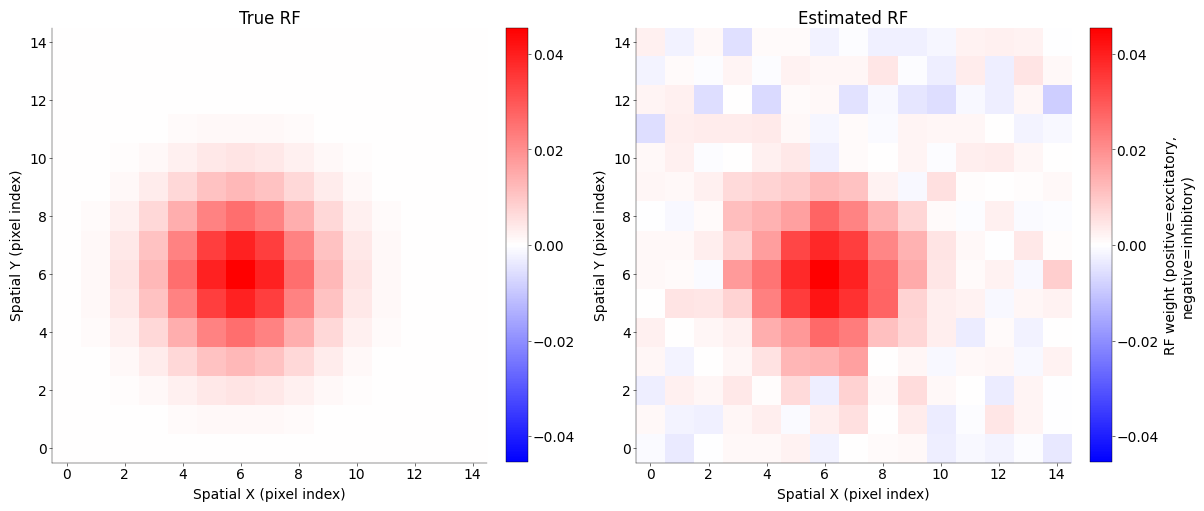

In [22]:
# ------------------------------------
# Plot the ground truth and estimated
# `w` side by side. (1 pt)
# ------------------------------------

mosaic = [["True", "Estimated"]]
fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(12, 5))

# make sure to add a colorbar. 'bwr' is a reasonable choice for the cmap.
vlim = np.max(np.abs(w))

# True RF
im0 = ax["True"].imshow(
    w.reshape(w_est.shape), cmap="bwr", vmin=-vlim, vmax=vlim, origin="lower"
)
ax["True"].set_title("True RF")
ax["True"].set_xlabel("Spatial X (pixel index)")
ax["True"].set_ylabel("Spatial Y (pixel index)")
cbar0 = fig.colorbar(im0, ax=ax["True"], fraction=0.046, pad=0.04)

# Estimated RF
im1 = ax["Estimated"].imshow(w_est, cmap="bwr", vmin=-vlim, vmax=vlim, origin="lower")
ax["Estimated"].set_title("Estimated RF")
ax["Estimated"].set_xlabel("Spatial X (pixel index)")
ax["Estimated"].set_ylabel("Spatial Y (pixel index)")
cbar1 = fig.colorbar(im1, ax=ax["Estimated"], fraction=0.046, pad=0.04)
cbar1.set_label("RF weight (positive=excitatory,\nnegative=inhibitory)")

plt.show()

# Task 2: Apply to real neuron

Download the dataset for this task from Ilias (`nds_cl_5_data.mat`). It contains a stimulus matrix (`s`) in the same format you used before and the spike times. In addition, there is an array called `trigger` which contains the times at which the stimulus frames were swapped.

* Generate an array of spike counts at the same temporal resolution as the stimulus frames
* Fit the receptive field with time lags of 0 to 4 frames. Fit them one lag at a time (the ML fit is very sensitive to the number of parameters estimated and will not produce good results if you fit the full space-time receptive field for more than two time lags at once). 
* Plot the resulting filters

*Grading: 3.5 pts*


In [ ]:
var = io.loadmat("../data/nds_cl_5_data.mat")

# t contains the spike times of the neuron
t = var["DN_spiketimes"].flatten()

# trigger contains the times at which the stimulus flipped
trigger = var["DN_triggertimes"].flatten()

# contains the stimulus movie with black and white pixels
s = var["DN_stim"]
s = s.reshape((300, 1500))  # the shape of each frame is (20, 15)
s = s[:, 1 : len(trigger)]

Create vector of spike counts

In [ ]:
# ------------------------------------------
# Bin the spike counts at the same temporal
# resolution as the stimulus (0.5 pts)
# ------------------------------------------

Fit receptive field for each frame separately

In [ ]:
# ------------------------------------------
# Fit the receptive field with time lags of
# 0 to 4 frames separately (1 pt)
#
# The final receptive field (`w_hat`) should
# be in the shape of (Dx * Dy, 5)
# ------------------------------------------

# specify the time lags
delta = [0, 1, 2, 3, 4]

# fit for each delay

Plot the frames one by one and explain what you see.

In [ ]:
# --------------------------------------------
# Plot all 5 frames of the fitted RFs (1 pt)
# --------------------------------------------

fig, ax = plt.subplot_mosaic(mosaic=[delta], figsize=(10, 4), constrained_layout=True)

_Explanation (1 pt)_
...

# Task 3: Separate space/time components

The receptive field of the neuron can be decomposed into a spatial and a temporal component. Because of the way we computed them, both are independent and the resulting spatio-temporal component is thus called separable. As discussed in the lecture, you can use singular-value decomposition to separate these two: 

$$
W = u_1 s_1 v_1^T
$$

Here $u_1$ and $v_1$ are the singular vectors belonging to the 1st singular value $s_1$ and provide a long rank approximation of W, the array with all receptive fields. It is important that the mean is subtracted before computing the SVD.  

Plot the first temporal component and the first spatial component. You can use a Python implementation of SVD. The results can look a bit puzzling, because the sign of the components is arbitrary.

*Grading: 1.5 pts*

In [ ]:
# --------------------------------------------
# Apply SVD to the fitted receptive field,
# you can use either numpy or sklearn (0.5 pt)
# --------------------------------------------



In [ ]:
# -------------------------------------------------
# Plot the spatial and temporal components (1 pt)
# -------------------------------------------------

fig, ax = plt.subplot_mosaic(
    mosaic=[["Spatial", "Temporal"]], figsize=(10, 4), constrained_layout=True
)
# add plot

# Task 4: Regularized receptive field

As you can see, maximum likelihood estimation of linear receptive fields can be quite noisy, if little data is available. 

To improve on this, one can regularize the receptive field vector and a term to the cost function


$$
C(w) = L(w) + \alpha ||w||_p^2
$$

Here, the $p$ indicates which norm of $w$ is used: for $p=2$, this is shrinks all coefficient equally to zero; for $p=1$, it favors sparse solutions, a penality also known as lasso. Because the 1-norm is not smooth at zero, it is not as straightforward to implement "by hand". 

Use a toolbox with an implementation of the lasso-penalization and fit the receptive field. Possibly, you will have to try different values of the regularization parameter $\alpha$. Plot your estimates from above and the lasso-estimates. How do they differ? What happens when you increase or decrease $alpha$?

If you want to keep the Poisson noise model, you can use the implementation in [`pyglmnet`](https://pypi.python.org/pypi/pyglmnet). Otherwise, you can also resort to the linear model from `sklearn` which assumes Gaussian noise (which in my hands was much faster).

*Grading: 3 pts*


In [ ]:
from sklearn import linear_model

# ------------------------------------------
# Fit the receptive field with time lags of
# 0 to 4 frames separately (the same as before)
# with sklearn or pyglmnet for different values
# of alpha (1 pt)
# ------------------------------------------

delta = [0, 1, 2, 3, 4]
alphas= []

In [ ]:
# ------------------------------------------
# plot the estimated receptive fields (1 pt)
# ------------------------------------------


fig, ax = plt.subplots(
    len(alphas), len(delta), figsize=(10, 4), constrained_layout=True
)# add plot

_Explanation (1 pt)_
...

## Bonus Task (Optional): Spike Triggered Average

Instead of the Maximum Likelihood implementation above, estimate the receptive field using the spike triggered average.
Use it to increase the temporal resolution of your receptive field estimate.
Perform the SVD analysis for your STA-based receptive field and plot the spatial and temporal kernel as in Task 3.

**Questions:**
1. Explain how / why you chose a specific time delta.
2. Reconsider what you know about STA. Is it suitable to use STA for this data? Why/why not? What are the (dis-)advantages of using the MLE based method from above?

_Grading: 1 BONUS Point._


_BONUS Points do not count for this individual coding lab, but sum up to 5% of your **overall coding lab grade**. There are 4 BONUS points across all coding labs._